In [38]:
import pickle
import os
import gzip
import urllib

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

ImportError: No module named Image

In [ ]:
trainset_labeled = pickle.load(open("data/train_labeled.p", "rb"))

In [10]:
def download_mnist(local_path):
    url_root = "http://yann.lecun.com/exdb/mnist/"
    for f_name in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        f_path = os.path.join(local_path, f_name)
        if not os.path.exists(f_path):
            download_file(url_root + f_name, f_path)

def download_file(url, local_path):
    dir_path = os.path.dirname(local_path)
    if not os.path.exists(dir_path):
        print("Creating the directory '%s' ..." % dir_path)
        os.makedirs(dir_path)

    print("Downloading from '%s' ..." % url)
    urllib.URLopener().retrieve(url, local_path)

In [88]:
def rotate_coords(x, y, theta, ox, oy):
    """Rotate arrays of coordinates x and y by theta radians about the
    point (ox, oy).

    """
    s, c = np.sin(theta), np.cos(theta)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

def rotate_image(src, theta, ox, oy, fill=255):
    """Rotate the image src by theta radians about (ox, oy).
    Pixels in the result that don't correspond to pixels in src are
    replaced by the value fill.

    """
    # Images have origin at the top left, so negate the angle.
    theta = -theta

    # Dimensions of source image. Note that scipy.misc.imread loads
    # images in row-major order, so src.shape gives (height, width).
    sh, sw = src.shape

    # Rotated positions of the corners of the source image.
    cx, cy = rotate_coords([0, sw, sw, 0], [0, 0, sh, sh], theta, ox, oy)

    # Determine dimensions of destination image.
    dw, dh = (int(np.ceil(c.max() - c.min())) for c in (cx, cy))

    # Coordinates of pixels in destination image.
    dx, dy = np.meshgrid(np.arange(dw), np.arange(dh))

    # Corresponding coordinates in source image. Since we are
    # transforming dest-to-src here, the rotation is negated.
    sx, sy = rotate_coords(dx + cx.min(), dy + cy.min(), -theta, ox, oy)

    # Select nearest neighbour.
    sx, sy = sx.round().astype(int), sy.round().astype(int)

    # Mask for valid coordinates.
    mask = (0 <= sx) & (sx < sw) & (0 <= sy) & (sy < sh)

    # Create destination image.
    dest = np.empty(shape=(dh, dw), dtype=src.dtype)

    # Copy valid coordinates from source image.
    dest[dy[mask], dx[mask]] = src[sy[mask], sx[mask]]

    # Fill invalid coordinates.
    dest[dy[~mask], dx[~mask]] = fill

    return dest

In [ ]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [35]:
def imshow(img):
    npimg = img.reshape(28,28)
    plt.imshow(npimg, cmap='gray')

In [14]:
download_mnist('data/')

In [18]:
with gzip.open(os.path.join('data/', 'train-images-idx3-ubyte.gz')) as fd:
        buf = fd.read()
        loaded = np.frombuffer(buf, dtype=np.uint8)
        trX = loaded[16:].reshape((60000, 28 * 28)).astype(float)

In [131]:
def grey_inverse(img):
    new_img = []
    for x in img:
        new_img.append(255.0-x)
    return np.array(new_img)

def sharpen(img):
    new_img = []
    for x in img:
        if x > 185: 
            x = 255
        elif x < 75:
            x = 0
        
        new_img.append(x)
    return np.array(new_img)
        

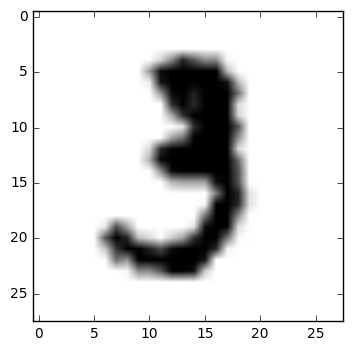

In [134]:
imshow(grey_inverse(trX[10]))

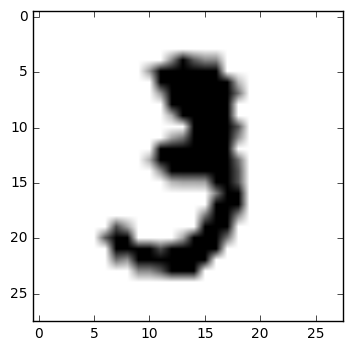

In [135]:
imshow(sharpen(grey_inverse(trX[10])))

In [93]:
zzz = rotate_image(grey_inverse(trX[10]).reshape(28,28), .5, 100,100)

In [94]:
zzz.shape

(38L, 38L)

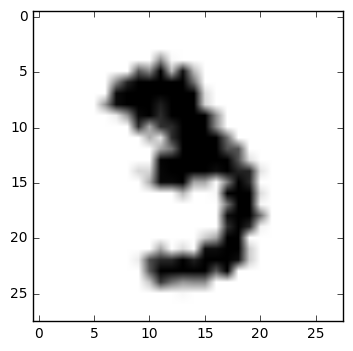

In [95]:
plt.imshow(zzz[5:33,5:33], cmap='gray')

In [ ]:
plt.imshow(zzz[5:33, 5:33], cmap='gray')

In [31]:
trX[0].reshape(28,28).shape

(28L, 28L)